In [1]:
import os
import sys
import logging
import numpy as np

import torch
from torch.utils.data import DataLoader

In [2]:
from IPython.display import SVG, display

%matplotlib inline 
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

In [15]:
sys.path.append("/tmp/pycharm_project_660/src")
from plotter import *
from model import DeepSTPP, log_ft, t_intensity, s_intensity
from data.dataset import SlidingWindowWrapper
from data.synthetic import *
from util import *

In [4]:
"""The code below is used to set up customized training device on computer"""
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("You are using GPU acceleration.")
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("CUDA is not Available. You are using CPU only.")
    print("Number of cores: ", os.cpu_count())

You are using GPU acceleration.
Device name:  NVIDIA GeForce RTX 2080 Ti
Number of CUDAs(cores):  8


In [10]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1, 
                   lr=0.0003, momentum=0.9, epochs=50, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-3, b_max=20, 
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='sigmoid', sample=True, decoder_n_layer=3)

In [11]:
"""
Prepare logger
"""
logger = logging.getLogger('full_lookahead{}batch{}'.format(config.lookahead, config.batch))
logger.setLevel(logging.DEBUG)
hdlr = logging.FileHandler('full_lookahead{}batch{}.log'.format(config.lookahead, config.batch))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

## COVID NJ cases

In [7]:
dataset = 'covid_nj_cases'
npzf = np.load(f'/tmp/pycharm_project_660/data/processed/{dataset}.npz', allow_pickle=True)

In [8]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)
valset   = SlidingWindowWrapper(npzf['val'],   normalized=True, min=trainset.min, max=trainset.max)
testset  = SlidingWindowWrapper(npzf['test'],  normalized=True, min=trainset.min, max=trainset.max)

In [12]:
train_loader = DataLoader(trainset, batch_size=config.batch, shuffle=True)
val_loader   = DataLoader(valset,   batch_size=config.batch, shuffle=False)
test_loader  = DataLoader(testset,  batch_size=config.batch, shuffle=False)

In [25]:
config.epochs = 20

In [27]:
import torch
import numpy as np
import copy

from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def visualize_diff(outputs, targets, portion=1):
    outputs = outputs[:int(len(outputs) * portion)]
    targets = targets[:int(len(targets) * portion)]

    plt.figure(figsize=(14, 10), dpi=180)
    plt.subplot(2, 2, 1)

    n = outputs.shape[0]
    lookahead = outputs.shape[1]

    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 0], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 0], "-o", color="b", label="Actual")
    plt.ylabel('Latitude')
    plt.legend()

    plt.subplot(2, 2, 2)
    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 1], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 1], "-o", color="b", label="Actual")
    plt.ylabel('Longitude')
    plt.legend()

    plt.subplot(2, 2, 3)
    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 2], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 2], "-o", color="b", label="Actual")
    plt.ylabel('delta_t (hours)')
    plt.legend()
    plt.savefig('result.png')


def eval_loss(model, test_loader, device):
    model.eval()
    loss_total = 0
    sll_meter = AverageMeter()
    tll_meter = AverageMeter()
    loss_meter = AverageMeter()

    for index, data in enumerate(test_loader):
        st_x, st_y, _, _, _ = data
        loss, sll, tll = model.loss(st_x, st_y)

        loss_meter.update(loss.item())
        sll_meter.update(sll.mean())
        tll_meter.update(tll.mean())

    return loss_meter.avg, sll_meter.avg, tll_meter.avg


def eval_loss_rmtpp(model, test_loader, device):
    model.eval()
    loss_total = 0
    loss_meter = AverageMeter()

    for index, data in enumerate(test_loader):
        st_x, st_y, _, _, _ = data
        loss = model.loss(st_x, st_y)

        loss_meter.update(loss.item())

    return loss_meter.avg


def train_rmtpp(model, train_loader, val_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=50, gamma=0.2)
    best_eval = np.infty
    loss_meter = AverageMeter()

    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, data in tenumerate(train_loader):
            st_x, st_y, _, _, _ = data

            model.optimizer.zero_grad()
            loss = model.loss(st_x, st_y)

            if torch.isnan(loss):
                print("Numerical error, quiting...")
                return best_model

            loss.backward()
            model.optimizer.step()

            loss_meter.update(loss.item())

        scheduler.step()

        logger.info("In epochs {} | Loss: {:5f}".format(
            epoch, loss_meter.avg
        ))
        if (epoch+1)%config.eval_epoch==0:
            print("Evaluate")
            valloss = eval_loss_rmtpp(model, val_loader, device)
            logger.info("Val Loss {:5f} ".format(valloss))
            if valloss < best_eval:
                best_eval = valloss
                best_model = copy.deepcopy(model)

    print("training done!")
    return best_model


def train(model, train_loader, val_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=50, gamma=0.2)
    best_eval = np.infty
    sll_meter = AverageMeter()
    tll_meter = AverageMeter()
    loss_meter = AverageMeter()

    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, data in tenumerate(train_loader):
            st_x, st_y, _, _, _ = data

            model.optimizer.zero_grad()
            loss, sll, tll = model.loss(st_x, st_y)

            if torch.isnan(loss):
                print("Numerical error, quiting...")
                return best_model

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip)
            model.optimizer.step()

            loss_meter.update(loss.item())
            sll_meter.update(sll.mean())
            tll_meter.update(tll.mean())

        scheduler.step()

        logger.info("In epochs {} | "
                    "total loss: {:5f} | Space: {:5f} | Time: {:5f}".format(
            epoch, loss_meter.avg, sll_meter.avg , tll_meter.avg
        ))
        if (epoch+1)%config.eval_epoch==0:
            print("Evaluate")
            valloss, valspace, valtime = eval_loss(model, val_loader, device)
            logger.info("Val Loss {:5f} | Space: {:5f} | Time: {:5f}".format(valloss, valspace, valtime))
            if valloss < best_eval:
                best_eval = valloss
                best_model = copy.deepcopy(model)

    print("training done!")
    return best_model


def mult_eval(models, n_eval, dataset, test_loader, config, device, scales, rmtpp=False):
    time_scale = np.log(scales[-1])
    space_scale = np.log(np.prod(scales[:2]))

    sll_list = []
    tll_list = []
    with torch.no_grad():
        for model in models:
            model.eval()
            for _ in trange(n_eval):
                if rmtpp:
                    tll = eval_loss_rmtpp(model, test_loader, device)
                    sll_list.append(0.0)
                    tll_list.append(-tll - time_scale)
                else:
                    _, sll, tll = eval_loss(model, test_loader, device)
                    sll_list.append(sll.item() - space_scale)
                    tll_list.append(tll.item() - time_scale)

    print("%.4f" % np.mean(sll_list), '±', "%.4f" % np.std(sll_list))
    print("%.4f" % np.mean(tll_list), '±', "%.4f" % np.std(tll_list))


In [29]:
config.epochs = 10

In [30]:
from model import *
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)
torch.save(best_model.state_dict(), f'/tmp/pycharm_project_660/models/{dataset}_0.mod')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:39:46,139 INFO In epochs 0 | total loss: 0.197768 | Space: 0.891084 | Time: 3.629666


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:40:11,271 INFO In epochs 1 | total loss: 0.096617 | Space: 1.060860 | Time: 3.658089


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:40:35,879 INFO In epochs 2 | total loss: 0.062879 | Space: 1.124538 | Time: 3.666505


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:40:59,835 INFO In epochs 3 | total loss: 0.046000 | Space: 1.158335 | Time: 3.670665


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:41:23,959 INFO In epochs 4 | total loss: 0.035866 | Space: 1.179550 | Time: 3.673034


Evaluate


2022-07-15 12:41:24,203 INFO Val Loss -0.003367 | Space: 1.134538 | Time: 2.698284


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:41:49,146 INFO In epochs 5 | total loss: 0.029107 | Space: 1.193904 | Time: 3.674693


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:42:13,400 INFO In epochs 6 | total loss: 0.024276 | Space: 1.204291 | Time: 3.675936


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:42:38,074 INFO In epochs 7 | total loss: 0.020650 | Space: 1.212114 | Time: 3.676908


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:43:02,466 INFO In epochs 8 | total loss: 0.017830 | Space: 1.218368 | Time: 3.677616


  0%|          | 0/901 [00:00<?, ?it/s]

2022-07-15 12:43:27,683 INFO In epochs 9 | total loss: 0.015572 | Space: 1.223498 | Time: 3.678239


Evaluate


2022-07-15 12:43:27,913 INFO Val Loss -0.003480 | Space: 1.167698 | Time: 2.688405


training done!


PermissionError: [Errno 13] Permission denied: '/tmp/pycharm_project_660/models/covid_nj_cases_0.mod'

In [32]:
def plot_lambst_static(lambs, x_range, y_range, t_range, fps, scaler=None, cmin=None, cmax=None,
                       history=None, decay=0.3, base_size=300, cmap='magma', fn='result.mp4'):
    # Inverse transform the range to the actual scale
    if scaler is not None:
        x_range, y_range, t_range = inverse_transform(x_range, y_range, t_range, scaler)

    if cmin is None:
        cmin = 0
    if cmax is "outlier":
        cmax = np.max([np.max(lamb_st) for lamb_st in lambs])
    if cmax is None:
        cmax = np.max(lambs)
    print(f'Inferred cmax: {cmax}')
    cmid = cmin + (cmax - cmin) * 0.9

    grid_x, grid_y = np.meshgrid(x_range, y_range)

    frn = len(t_range) # frame number of the animation

    fig = plt.figure(figsize=(6,6), dpi=150)
    ax = fig.add_subplot(111, projection='3d', xlabel='x', ylabel='y', zlabel='λ', zlim=(cmin, cmax),
                         title='Spatio-temporal Conditional Intensity')
    ax.title.set_position([.5, .95])
    text = ax.text(min(x_range), min(y_range), cmax, "t={:.2f}".format(t_range[0]), fontsize=10)
    plot = [ax.plot_surface(grid_x, grid_y, lambs[0], rstride=1, cstride=1, cmap=cmap)]

    if history is not None:
        his_s, his_t = history
        zs = np.ones_like(lambs[0]) * cmid # add a platform for locations
        plat = ax.plot_surface(grid_x, grid_y, zs, rstride=1, cstride=1, color='white', alpha=0.2)
        points = ax.scatter3D([], [], [], color='black') # add locations
        plot.append(plat)
        plot.append(points)

    pbar = tqdm(total=frn + 2)

    def update_plot(frame_number):
        t = t_range[frame_number]
        plot[0].remove()
        plot[0] = ax.plot_surface(grid_x, grid_y, lambs[frame_number], rstride=1, cstride=1, cmap=cmap)
        text.set_text('t={:.2f}'.format(t))

        if history is not None:
            mask = np.logical_and(his_t <= t, his_t >= t_range[0])
            locs = his_s[mask]
            times = his_t[mask]
            sizes = np.exp((times - t) * decay) * base_size
            zs = np.ones_like(sizes) * cmid
            plot[2].remove()
            plot[2] = ax.scatter3D(locs[:, 0], locs[:, 1], zs, c='black', s=sizes, marker='x')

        pbar.update()

    ani = animation.FuncAnimation(fig, update_plot, frn, interval=1000/fps)
    ani.save(fn, writer='ffmpeg', fps=fps)
    return ani

<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_60049/2955257576.py:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cmax is "outlier":


Intensity time range : 7.0


  0%|          | 0/200 [00:00<?, ?it/s]

Inferred cmax: 184.89353942871094


  0%|          | 0/202 [00:00<?, ?it/s]

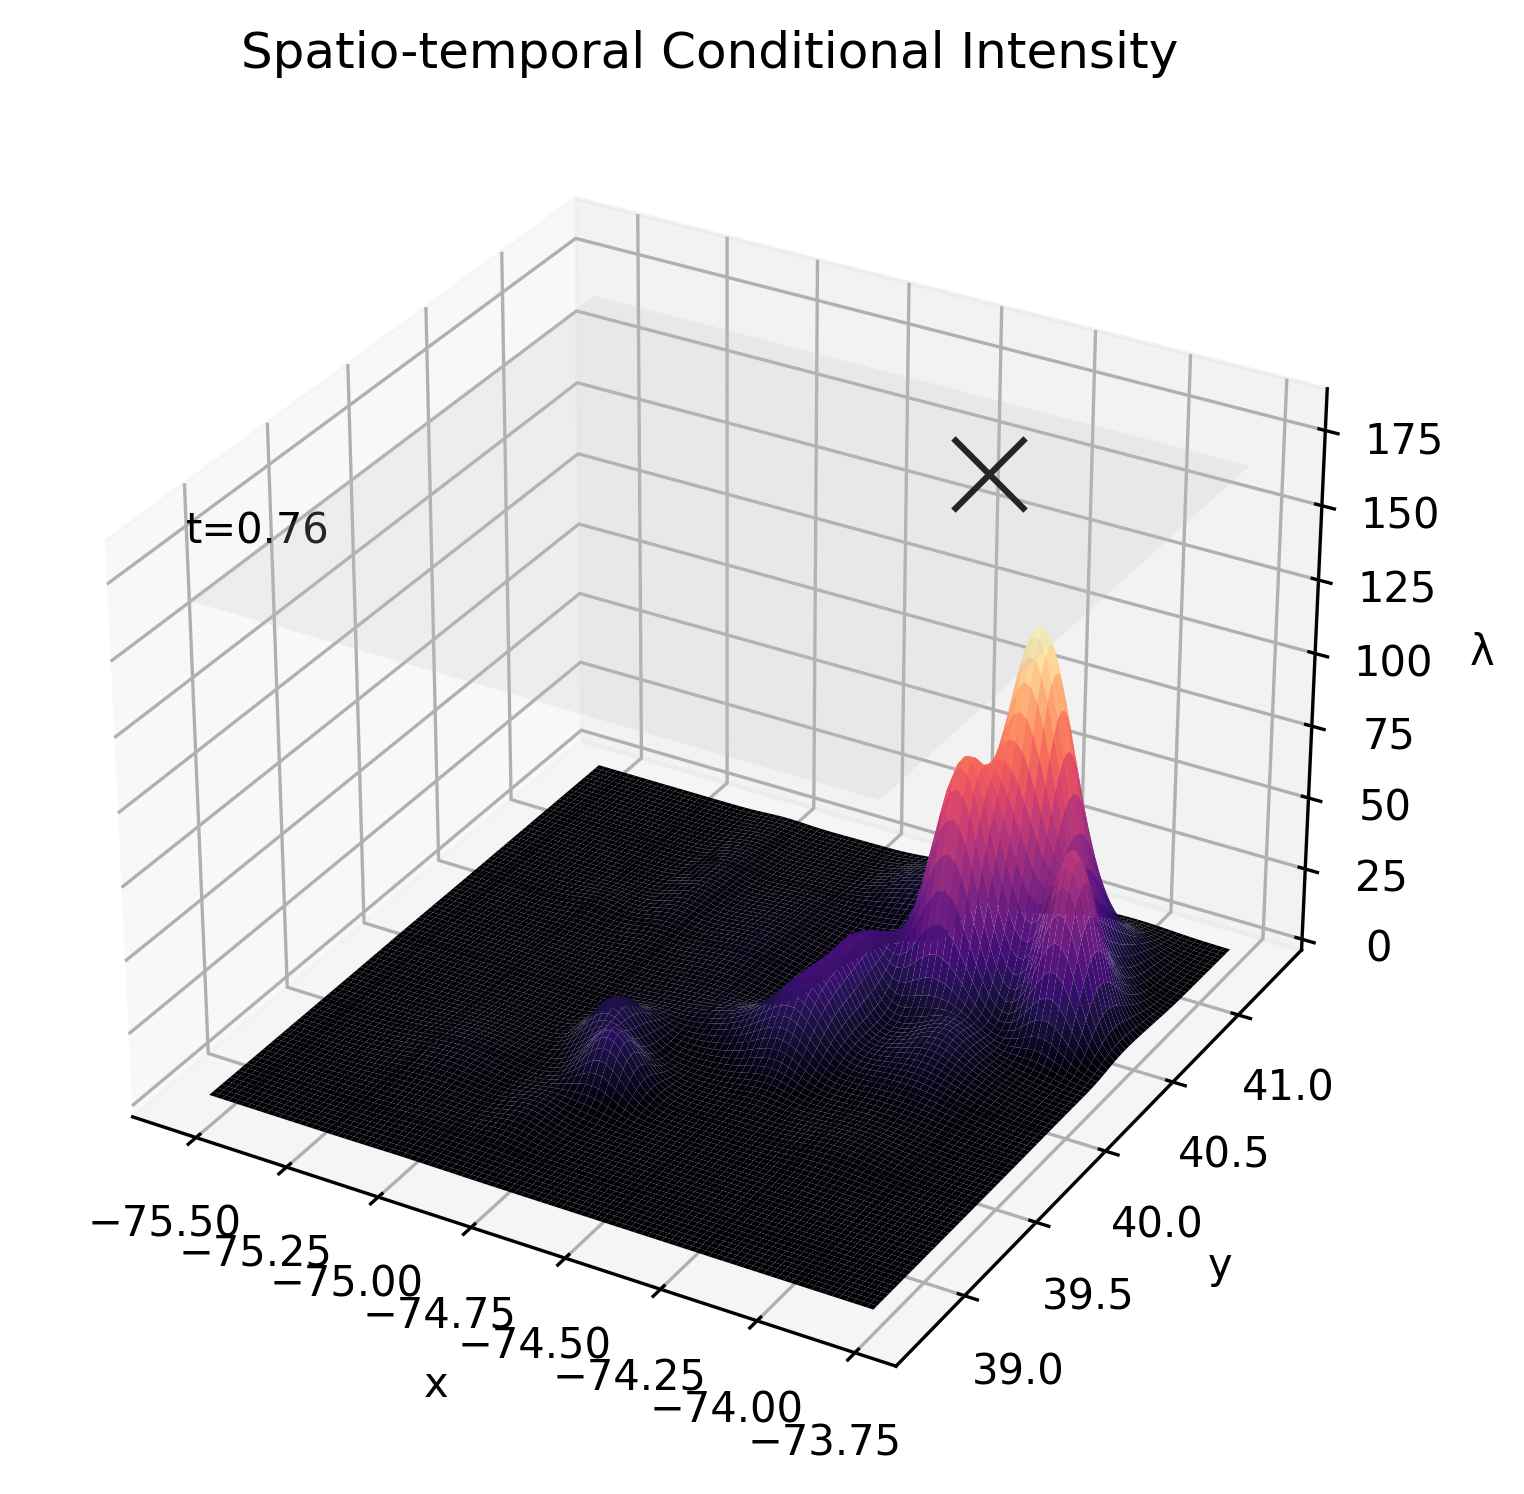

In [35]:
scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
lambs, x_range, y_range, t_range, his_s, his_t = calc_lamb(model, test_loader, config, device, scales, biases, total_time=7.0, round_time=False)
plot_lambst_static(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=10,
                   scaler=None, fps=12, fn=f'/tmp/pycharm_project_660/new.mp4')


In [ ]:
"""
lambs: list, len(lambs) = len(t_range), element: [len(x_range), len(y_range)]
fps: # frame per sec
fn: file_name

The result could be saved as file with command `ani.save('file_name.mp4', writer='ffmpeg', fps=fps)`
                                    or command `ani.save('file_name.gif', writer='imagemagick', fps=fps)`
"""
def plot_lambst_static(lambs, x_range, y_range, t_range, fps, scaler=None, cmin=None, cmax=None,
                       history=None, decay=0.3, base_size=300, cmap='magma', fn='result.mp4'):
    # Inverse transform the range to the actual scale
    if scaler is not None:
        x_range, y_range, t_range = inverse_transform(x_range, y_range, t_range, scaler)

    if cmin is None:
        cmin = 0
    if cmax is "outlier":
        cmax = np.max([np.max(lamb_st) for lamb_st in lambs])
    if cmax is None:
        cmax = np.max(lambs)
    print(f'Inferred cmax: {cmax}')
    cmid = cmin + (cmax - cmin) * 0.9

    grid_x, grid_y = np.meshgrid(x_range, y_range)

    frn = len(t_range) # frame number of the animation

    fig = plt.figure(figsize=(6,6), dpi=150)
    ax = fig.add_subplot(111, projection='3d', xlabel='x', ylabel='y', zlabel='λ', zlim=(cmin, cmax),
                         title='Spatio-temporal Conditional Intensity')
    ax.title.set_position([.5, .95])
    text = ax.text(min(x_range), min(y_range), cmax, "t={:.2f}".format(t_range[0]), fontsize=10)
    plot = [ax.plot_surface(grid_x, grid_y, lambs[0], rstride=1, cstride=1, cmap=cmap)]

    if history is not None:
        his_s, his_t = history
        zs = np.ones_like(lambs[0]) * cmid # add a platform for locations
        plat = ax.plot_surface(grid_x, grid_y, zs, rstride=1, cstride=1, color='white', alpha=0.2)
        points = ax.scatter3D([], [], [], color='black') # add locations
        plot.append(plat)
        plot.append(points)

    pbar = tqdm(total=frn + 2)

    def update_plot(frame_number):
        t = t_range[frame_number]
        plot[0].remove()
        plot[0] = ax.plot_surface(grid_x, grid_y, lambs[frame_number], rstride=1, cstride=1, cmap=cmap)
        text.set_text('t={:.2f}'.format(t))

        if history is not None:
            mask = np.logical_and(his_t <= t, his_t >= t_range[0])
            locs = his_s[mask]
            times = his_t[mask]
            sizes = np.exp((times - t) * decay) * base_size
            zs = np.ones_like(sizes) * cmid
            plot[2].remove()
            plot[2] = ax.scatter3D(locs[:, 0], locs[:, 1], zs, c='black', s=sizes, marker='x')

        pbar.update()

    ani = animation.FuncAnimation(fig, update_plot, frn, interval=1000/fps)
    ani.save(fn, writer='ffmpeg', fps=fps)
    return ani

In [ ]:
scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
lambs, x_range, y_range, t_range, his_s, his_t = calc_lamb(model, test_loader, config, device, scales, biases, total_time=7.0, round_time=False)
plot_lambst_static(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=10,
                   scaler=None, fps=12, fn=f'../video/{dataset}.mp4')
